# Neural Network - with single input and hidden layer

In this note, I am going to train a neural network model with `gradient decent` estimation. This model will only have 1 direct inputs and 1 hidden layer with 1 neuron and logistic transform. The hidden layer will be build with Gaussian radial basis function (**RBF**)and the output layer will use logistic function to have non-linear transformation. 
This model is simple enough to understand how `back propagation` works. 

# Overview

This note will covere:
* Prepare the data
* Model and Cost function
* Backward propagation
* Code implementation

# Prepare the data

In [1]:
# Python imports
import numpy as np # Matrix and vector computation package
import matplotlib.pyplot as plt  # Plotting library
from matplotlib.colors import colorConverter, ListedColormap # some plotting functions
from mpl_toolkits.mplot3d import Axes3D  # 3D plots
from matplotlib import cm # Colormaps
# Allow matplotlib to plot inside this notebook
%matplotlib inline
# Set the seed of the numpy random number generator so that the tutorial is reproducable
np.random.seed(seed=1)

Here we are generating 20 data points from 2 class distributions: blue $(t=1)$ and red $(t=-1)$. The Red data points will be intentionally generated based on 2 differenct mean so that it will surround blue in both positive and negative direction.

In [2]:
#Define and generate the samples
nb_of_samples_per_class = 20  # The number of sample in each class
blue_mean = [0]  # The mean of the blue class
red_left_mean = [-2]  # The mean of the red class
red_right_mean = [2]  # The mean of the red class

std_dev = 0.5  # standard deviation of both classes
# Generate samples from both classes
x_blue = np.random.randn(nb_of_samples_per_class, 1) * std_dev + blue_mean
x_red_left = np.random.randn(nb_of_samples_per_class//2, 1) * std_dev + red_left_mean
x_red_right = np.random.randn(nb_of_samples_per_class//2, 1) * std_dev + red_right_mean

# Merge samples in set of input variables x, and corresponding set of
# output variables t
x = np.vstack((x_blue, x_red_left, x_red_right))
t = np.vstack((np.ones((x_blue.shape[0],1)), 
               np.zeros((x_red_left.shape[0],1)), 
               np.zeros((x_red_right.shape[0], 1))))
#Define and generate the samples
nb_of_samples_per_class = 20  # The number of sample in each class
blue_mean = [0]  # The mean of the blue class
red_left_mean = [-2]  # The mean of the red class
red_right_mean = [2]  # The mean of the red class

std_dev = 0.5  # standard deviation of both classes
# Generate samples from both classes
x_blue = np.random.randn(nb_of_samples_per_class, 1) * std_dev + blue_mean
x_red_left = np.random.randn(nb_of_samples_per_class//2, 1) * std_dev + red_left_mean
x_red_right = np.random.randn(nb_of_samples_per_class//2, 1) * std_dev + red_right_mean

# Merge samples in set of input variables x, and corresponding set of
# output variables t
x = np.vstack((x_blue, x_red_left, x_red_right))
t = np.vstack((np.ones((x_blue.shape[0],1)), 
               np.zeros((x_red_left.shape[0],1)), 
               np.zeros((x_red_right.shape[0], 1))))

As you can see from the plot below. The data is **NOT** `linear separatable`. That's why we need to use non-linear transformation to train the model.

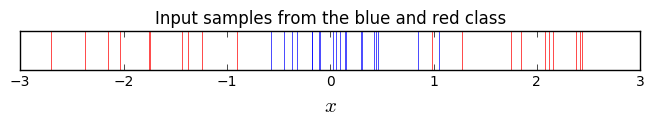

In [3]:
# Plot samples from both classes as lines on a 1D space
plt.figure(figsize=(8,0.5))
plt.xlim(-3,3)
plt.ylim(-1,1)
# Plot samples
plt.plot(x_blue, np.zeros_like(x_blue), 'b|', ms = 30) 
plt.plot(x_red_left, np.zeros_like(x_red_left), 'r|', ms = 30) 
plt.plot(x_red_right, np.zeros_like(x_red_right), 'r|', ms = 30) 
plt.gca().axes.get_yaxis().set_visible(False)
plt.title('Input samples from the blue and red class')
plt.xlabel('$x$', fontsize=15)
plt.show()

# Model and Cost Function

Model can be visualized as below:  
<p align="center">
<img src="https://raw.githubusercontent.com/weichetaru/weichetaru.github.com/master/notebook/machine-learning/img/SimpleANN03.png"></p>

Specifically, for hidden layer **h**:

$$\mathbf{h} = \phi(\mathbf{x}*w_h) = e^{-(\mathbf{x}*w_h)^2}$$

where

$$\text{RBF} = \phi(z) = e^{-z^2}$$

For **y**:
$$\mathbf{y} = \sigma(\mathbf{h} * w_o - 1) = \frac{1}{1+e^{-\mathbf{h} * w_o - 1}}$$

Note the -1 to present bias(intercept) term. Usually it should also trained by model but to keep model simple here we simply use contant -1. 

We still use `cross-entropy cost function`.  
As we specified before in [Logistic Regression](https://weichetaru.github.io/machine-learning/2016/11/23/deep_learning-logistic-regression-gradient-decent#Loss-function,-chain-rule-and-its-derivative) For Binary variable. It should be: 

$$\xi(t_i,y_i) = - \left[ t_i log(y_i) + (1-t_i)log(1-y_i) \right]$$

The model and functions specified above is what we usually call `forward step` in neural network. It will produce error/cost/gradient which we will use to adjust parameters during `backward propagation`.   

We can at first specify the forward step into code and plot the cost function. 

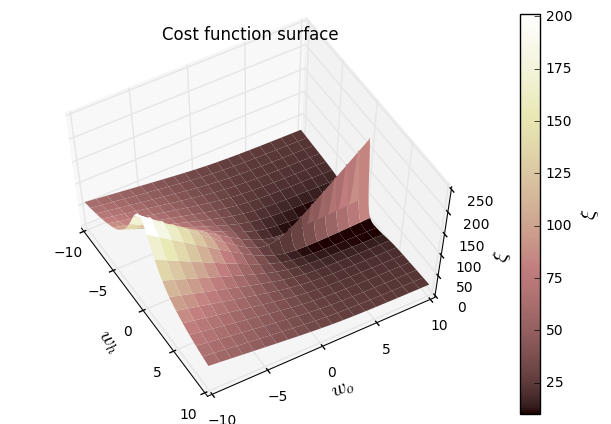

In [4]:
# Define the rbf function
def rbf(z):
    return np.exp(-z**2)

# Define the logistic function
def logistic(z): 
    return 1 / (1 + np.exp(-z))

# Function to compute the hidden activations
def hidden_activations(x, wh):
    return rbf(x * wh)

# Define output layer feedforward
def output_activations(h , wo):
    return logistic(h * wo - 1)

# Define the neural network function
def nn(x, wh, wo): 
    return output_activations(hidden_activations(x, wh), wo)

# Define the neural network prediction function that only returns
#  1 or 0 depending on the predicted class
def nn_predict(x, wh, wo): 
    return np.around(nn(x, wh, wo))

# Define the cost function
def cost(y, t):
    return - np.sum(np.multiply(t, np.log(y)) + np.multiply((1-t), np.log(1-y)))

# Define a function to calculate the cost for a given set of parameters
def cost_for_param(x, wh, wo, t):
    return cost(nn(x, wh, wo) , t)

# Plot the cost in function of the weights
# Define a vector of weights for which we want to plot the cost
nb_of_ws = 200 # compute the cost nb_of_ws times in each dimension
wsh = np.linspace(-10, 10, num=nb_of_ws) # hidden weights
wso = np.linspace(-10, 10, num=nb_of_ws) # output weights
ws_x, ws_y = np.meshgrid(wsh, wso) # generate grid
cost_ws = np.zeros((nb_of_ws, nb_of_ws)) # initialize cost matrix
# Fill the cost matrix for each combination of weights
for i in range(nb_of_ws):
    for j in range(nb_of_ws):
        cost_ws[i,j] = cost(nn(x, ws_x[i,j], ws_y[i,j]) , t)
# Plot the cost function surface
fig = plt.figure()
ax = Axes3D(fig)
# plot the surface
surf = ax.plot_surface(ws_x, ws_y, cost_ws, linewidth=0, cmap=cm.pink)
ax.view_init(elev=60, azim=-30)
cbar = fig.colorbar(surf)
ax.set_xlabel('$w_h$', fontsize=15)
ax.set_ylabel('$w_o$', fontsize=15)
ax.set_zlabel('$\\xi$', fontsize=15)
cbar.ax.set_ylabel('$\\xi$', fontsize=15)
plt.title('Cost function surface')
plt.grid()
plt.show()

### Still Convex ? 

As you can see. The cost function is not convex anymore and has a very sharp gradient.  We need to pay attention to keep learning rate small to reach a global minimum. 

# Backward propagation

The backward step will begin with computing the cost at the output node. This cost will then be propagated backwards layer by layer through the network to update the parameters. The gradient descent algorithm is used in every layer to update the parameters in the direction of the negative gradient .

Both $w_h$ and $w_o$ are updated: 

$$w(k+1) = w(k) - \Delta w(k+1)$$

$$\Delta w = \mu * {\partial \xi}/{\partial w}$$

We start from output layer (Note the result is what we produced in [Logistic Regression](https://weichetaru.github.io/machine-learning/2016/11/23/deep_learning-logistic-regression-gradient-decent#Loss-function,-chain-rule-and-its-derivative). Here simply replace $x_i$ with $h_i$): 

$$\frac{\partial \xi_i}{\partial w_o} = \frac{\partial z_{oi}}{\partial w_o} \frac{\partial y_i}{\partial z_{oi}} \frac{\partial \xi_i}{\partial y_i} = h_i (y_i-t_i) = h_i * \delta_{oi}$$

Note here $z_{oi} = h_i * w_o$ and ${\partial \xi_i}/{\partial z_{oi}} = \delta_{oi}$

For Hidden layer, still use `chain rule`:

$$\frac{\partial \xi_i}{\partial w_{h}} = \frac{\partial z_{hi}}{\partial w_{h}} \frac{\partial h_i}{\partial z_{hi}} \frac{\partial \xi_i}{\partial h_i}$$


Note here $z_{hi} = x_i * w_{h}$ and ${\partial \xi_i}/{\partial z_{hi}} = \delta_{hi}$.   

How to define $\delta_{hi}$? Simple, still use `chain rule`: 

$$\delta_{hi} = \frac{\partial \xi_i}{\partial z_{hi}} = \frac{\partial h_i}{\partial z_{hi}} \frac{\partial z_{oi}}{\partial h_i} \frac{\partial \xi_i}{\partial z_{oi}} 
= (-2 * z_{hi} * h_i) * w_{o} * (y_i - t_i) = -2 * z_{hi} * h_i * w_{o} * \delta_{oi}$$

Note for $\frac{\partial h_i}{\partial z_{hi}}$:

$$\frac{\partial h_i}{\partial z_{hi}} = \frac{d \phi(z)}{dz} = -2 z e^{-z^2} = -2 z \phi(z)$$ 

Therefore, 

$$\frac{\partial \xi_i}{\partial w_{h}} = x_i \delta_{hi}$$

# Code implementation

In [5]:
# Define the error function
def gradient_output(y, t):
    return y - t

# Define the gradient function for the weight parameter at the output layer
def gradient_weight_out(h, grad_output): 
    return  h * grad_output

# Define the gradient function for the hidden layer
def gradient_hidden(wo, grad_output):
    return wo * grad_output

# Define the gradient function for the weight parameter at the hidden layer
def gradient_weight_hidden(x, zh, h, grad_hidden):
    return x * -2 * zh * h * grad_hidden

# Define the update function to update the network parameters over 1 iteration
def backprop_update(x, t, wh, wo, learning_rate):
    # Compute the output of the network
    # This can be done with y = nn(x, wh, wo), but we need the intermediate 
    #  h and zh for the weight updates.
    zh = x * wh
    h = rbf(zh)  # hidden_activations(x, wh)
    y = output_activations(h, wo)
    # Compute the gradient at the output
    grad_output = gradient_output(y, t)
    # Get the delta for wo
    d_wo = learning_rate * gradient_weight_out(h, grad_output)
    # Compute the gradient at the hidden layer
    grad_hidden = gradient_hidden(wo, grad_output)
    # Get the delta for wh
    d_wh = learning_rate * gradient_weight_hidden(x, zh, h, grad_hidden)
    # return the update parameters
    return (wh-d_wh.sum(), wo-d_wo.sum())

$w_h$ and $w_o$ will be initialized with random and use backward propagation to update. 

In [6]:
# Run backpropagation
# Set the initial weight parameter
wh = 2
wo = -5
# Set the learning rate
learning_rate = 0.2

# Start the gradient descent updates and plot the iterations
nb_of_iterations = 50  # number of gradient descent updates
lr_update = learning_rate / nb_of_iterations # learning rate update rule
w_cost_iter = [(wh, wo, cost_for_param(x, wh, wo, t))]  # List to store the weight values over the iterations
for i in range(nb_of_iterations):
    learning_rate -= lr_update # decrease the learning rate
    # Update the weights via backpropagation
    wh, wo = backprop_update(x, t, wh, wo, learning_rate) 
    w_cost_iter.append((wh, wo, cost_for_param(x, wh, wo, t)))  # Store the values for plotting

# Print the final cost
print('final cost is {:.2f} for weights wh: {:.2f} and wo: {:.2f}'.format(cost_for_param(x, wh, wo, t), wh, wo))

final cost is 9.16 for weights wh: 1.44 and wo: 5.77


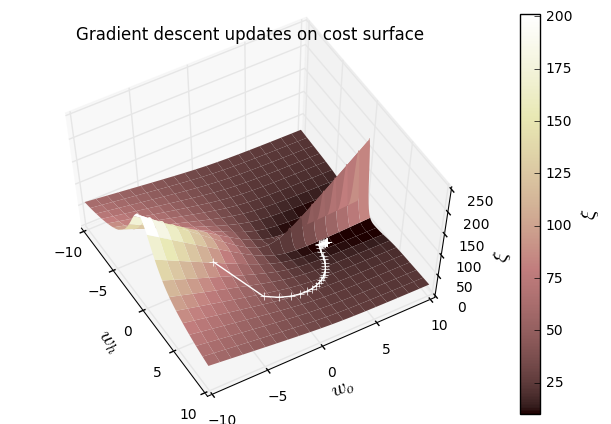

In [7]:
# Plot the weight updates on the error surface
# Plot the error surface
fig = plt.figure()
ax = Axes3D(fig)
surf = ax.plot_surface(ws_x, ws_y, cost_ws, linewidth=0, cmap=cm.pink)
ax.view_init(elev=60, azim=-30)
cbar = fig.colorbar(surf)
cbar.ax.set_ylabel('$\\xi$', fontsize=15)

# Plot the updates
for i in range(1, len(w_cost_iter)):
    wh1, wo1, c1 = w_cost_iter[i-1]
    wh2, wo2, c2 = w_cost_iter[i]
    # Plot the weight-cost value and the line that represents the update 
    ax.plot([wh1], [wo1], [c1], 'w+')  # Plot the weight cost value
    ax.plot([wh1, wh2], [wo1, wo2], [c1, c2], 'w-')
# Plot the last weights
wh1, wo1, c1 = w_cost_iter[len(w_cost_iter)-1]
ax.plot([wh1], [wo1], c1, 'w+')
# Shoz figure
ax.set_xlabel('$w_h$', fontsize=15)
ax.set_ylabel('$w_o$', fontsize=15)
ax.set_zlabel('$\\xi$', fontsize=15)
plt.title('Gradient descent updates on cost surface')
plt.grid()
plt.show()

The sample codes in this note come from [peterroelants.github.io](http://peterroelants.github.io/) where providing more details on neural netwrok and deep learning. It's very informative and highly recommanded. Here is more like my personal memo.